In [3]:
import os
import torch
import numpy as np
import pandas as pd
import nltk
import random
from collections import Counter
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data and Data Preprocessing

In [2]:
# specify date type and device type
dtype = torch.float
device = torch.device("cpu")

In [6]:
# initial peek of the training set
data = pd.read_csv("./hw2_data/snli_train.tsv", sep='\t', header = 0)
data.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [20]:
# initial peek of the validation set
vali = pd.read_csv("./hw2_data/snli_val.tsv", sep='\t', header = 0)
vali.head()

,sentence1,sentence2,label
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment
3,Man in overalls with two horses .,a man in overalls with two horses,entailment
4,Man observes a wavelength given off by an elec...,The man is examining what wavelength is given ...,entailment


In [26]:
# get shape of the data
data.shape, vali.shape

((100000, 3), (1000, 3))

In [8]:
# check for any missing values
data.isnull().sum(axis = 0)

sentence1    0
sentence2    0
label        0
dtype: int64

In [22]:
# check for any missing values
vali.isnull().sum(axis = 0)

sentence1    0
sentence2    0
label        0
dtype: int64

In [10]:
label_idx = {"entailment": 0, "contradiction": 1, "neutral": 2}

In [13]:
def load_data(PATH_TO_FILE):
    data = pd.read_csv(PATH_TO_FILE, sep='\t', header=0)
    s1_text = []
    s2_text = []
    label = []
    for idx, row in data.iterrows():
        s1 = row['sentence1'].lower()
        s2 = row['sentence2'].lower()
        label.append(label_idx[row['label'].lower()])
        s1_text.append(s1.split())
        s2_text.append(s2.split())
    return s1_text, s2_text, label

In [14]:
train_s1_text, train_s2_text, train_label = load_data("./hw2_data/snli_train.tsv")

In [18]:
val_s1_text, val_s2_text, val_label = load_data("./hw2_data/snli_val.tsv")

In [17]:
# print size of the training set
print(len(train_s1_text), len(train_s2_text), len(train_label))

100000 100000 100000


In [19]:
# print size of the validation set
print(len(val_s1_text), len(val_s2_text), len(val_label))

1000 1000 1000


In [25]:
# check all labels are numerical by now
all(type(item)==int for item in train_label)
all(type(item)==int for item in val_label)

True

In [27]:
PAD_IDX = 0
UNK_IDX = 1

In [38]:
def get_num_unique(d):
    unique = set()
    for l in d:
        for w in l:
            unique.add(w)
    return len(unique)

In [85]:
TRAIN_S1_VOCAB_SIZE = get_num_unique(train_s1_text)
TRAIN_S2_VOCAB_SIZE = get_num_unique(train_s2_text)
TRAIN_VOCAB_SIZE = get_num_unique(train_s1_text + train_s2_text)
print(TRAIN_S1_VOCAB_SIZE, TRAIN_S2_VOCAB_SIZE, TRAIN_VOCAB_SIZE)

15189 15699 21023


In [54]:
all_train_s1_tokens = [token for sublist in train_s1_text for token in sublist]
all_train_s2_tokens = [token for sublist in train_s2_text for token in sublist]
all_train_tokens = all_train_s1_tokens + all_train_s2_tokens
print(len(all_train_s1_tokens), len(all_train_s2_tokens), len(all_train_tokens))

1403863 824202 2228065


In [70]:
def build_vocab(all_tokens, MAX_VOCAB_SIZE):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(MAX_VOCAB_SIZE))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab))))
    id2token = ['PAD', 'UNK'] + id2token
    token2id['PAD'] = PAD_IDX
    token2id['UNK'] = UNK_IDX
    return token2id, id2token

In [71]:
token2id, id2token = build_vocab(all_train_tokens, TRAIN_VOCAB_SIZE)

In [87]:
# ADDED 'PAD' and 'UNK' into our vocabulary
TRAIN_VOCAB_SIZE += 2

In [72]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 7261 ; token reports
Token reports; token id 7261


In [73]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [74]:
train_s1_indices = token2index_dataset(train_s1_text)
train_s2_indices = token2index_dataset(train_s2_text)
val_s1_indices = token2index_dataset(val_s1_text)
val_s2_indices = token2index_dataset(val_s2_text)

In [75]:
# double checking
print ("Sentence 1 train dataset size is {}".format(len(train_s1_indices)))
print ("Sentence 2 train dataset size is {}".format(len(train_s2_indices)))
print ("Sentence 1 val dataset size is {}".format(len(val_s1_indices)))
print ("Sentence 2 val dataset size is {}".format(len(val_s2_indices)))

Sentence 1 train dataset size is 100000
Sentence 2 train dataset size is 100000
Sentence 1 val dataset size is 1000
Sentence 2 val dataset size is 1000


In [76]:
# get maximum sentence length
S1_MAX_SENTENCE_LENGTH = max([len(sublist) for sublist in train_s1_text])
S2_MAX_SENTENCE_LENGTH = max([len(sublist) for sublist in train_s2_text])
MAX_SENTENCE_LENGTH = max(S1_MAX_SENTENCE_LENGTH, S2_MAX_SENTENCE_LENGTH)
print(S1_MAX_SENTENCE_LENGTH, S2_MAX_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH)

82 41 82


In [96]:
TRAIN_VOCAB_SIZE == len(token2id) == len(id2token)

True

### Get Pretrained Word Vectors

In [90]:
# load fasttext pretrained word vectors
with open('./crawl-300d-2M.vec') as f:
    embedding_matrix = np.zeros((TRAIN_VOCAB_SIZE, 300))
    for i, line in enumerate(f):
        s = line.split()
        w = s[0].lower()
        v = np.asarray(s[1:])
        if w in token2id:
            embedding_matrix[token2id[w], :] = v
#         loaded_embeddings[i, :] = np.asarray(s[1:])

In [97]:
# save embedding_matrix for future use
np.save('embedding_matrix.npy', embedding_matrix)

In [ ]:
# load saved embedding_matrix
embedding_matrix = np.load('embedding_matrix.npy')

In [98]:
# print shape of the embedding matrix
embedding_matrix.shape

(21025, 300)

### Create Data Loader

In [157]:
class SnilDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, s1_data_list, s2_data_list, target_list, token2id):
        """
        @param data_list: list of tokens
        @param target_list: list of targets

        """
        self.s1_data_list, self.s2_data_list, self.target_list = s1_data_list, s2_data_list, target_list
        assert(len(self.s1_data_list) == len(self.target_list))
        assert(len(self.s2_data_list) == len(self.target_list))
        self.token2id = token2id

    def __len__(self):
        return len(self.s1_data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        s1_token_idx = self.s1_data_list[key][:MAX_SENTENCE_LENGTH]
        s2_token_idx = self.s2_data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [s1_token_idx, s2_token_idx, len(s1_token_idx), len(s2_token_idx), label]

In [164]:
def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_data_list = []
    s2_data_list = []
    label_list = []
    s1_length_list = []
    s2_length_list = []

    for datum in batch:
        label_list.append(datum[4])
        s1_length_list.append(datum[2])
        s2_length_list.append(datum[3])
    for datum in batch:
        s1_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        s1_data_list.append(s1_padded_vec)
        s2_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        s2_data_list.append(s2_padded_vec)
    return [torch.from_numpy(np.array(s1_data_list)), torch.from_numpy(np.array(s2_data_list)), torch.LongTensor(s1_length_list), torch.LongTensor(s2_length_list), torch.LongTensor(label_list)]

In [165]:
BATCH_SIZE = 128
train_dataset = SnilDataset(train_s1_indices, train_s2_indices, train_label, token2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)

In [168]:
val_dataset = SnilDataset(val_s1_indices, val_s2_indices, val_label, token2id)
val_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)

In [167]:
for i, (s1_data, s2_data, s1_lengths, s2_lengths, labels) in enumerate(train_loader):
    print(s1_data)
    print(s2_data)
    print(len(s1_lengths))
    print(len(s2_lengths))
    print(labels)
    break

tensor([[   2,   22,   24,  ...,    0,    0,    0],
        [   2,   13,    6,  ...,    0,    0,    0],
        [ 229,    4,  305,  ...,    0,    0,    0],
        ...,
        [ 458,  395,   55,  ...,    0,    0,    0],
        [  15,   10,   42,  ...,    0,    0,    0],
        [   2,    7, 1917,  ...,    0,    0,    0]])
tensor([[  2,  22,  24,  ...,   0,   0,   0],
        [ 14,  15,  10,  ...,   0,   0,   0],
        [  4,  63,  73,  ...,   0,   0,   0],
        ...,
        [ 30, 130,  10,  ...,   0,   0,   0],
        [ 51,  10,  15,  ...,   0,   0,   0],
        [  4,   7,   6,  ...,   0,   0,   0]])
128
128
tensor([2, 0, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2,
        2, 0, 2, 0, 0, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 1,
        0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2,
        2, 2, 2, 2, 0, 1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 1, 0, 1, 2, 2, 1, 1, 2, 1,
        1, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 

In [169]:
for i, (s1_data, s2_data, s1_lengths, s2_lengths, labels) in enumerate(val_loader):
    print(s1_data)
    print(s2_data)
    print(len(s1_lengths))
    print(len(s2_lengths))
    print(labels)
    break

tensor([[   2,   22,   24,  ...,    0,    0,    0],
        [   2,   13,    6,  ...,    0,    0,    0],
        [ 229,    4,  305,  ...,    0,    0,    0],
        ...,
        [ 458,  395,   55,  ...,    0,    0,    0],
        [  15,   10,   42,  ...,    0,    0,    0],
        [   2,    7, 1917,  ...,    0,    0,    0]])
tensor([[  2,  22,  24,  ...,   0,   0,   0],
        [ 14,  15,  10,  ...,   0,   0,   0],
        [  4,  63,  73,  ...,   0,   0,   0],
        ...,
        [ 30, 130,  10,  ...,   0,   0,   0],
        [ 51,  10,  15,  ...,   0,   0,   0],
        [  4,   7,   6,  ...,   0,   0,   0]])
128
128
tensor([2, 0, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2,
        2, 0, 2, 0, 0, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 1,
        0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2,
        2, 2, 2, 2, 0, 1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 1, 0, 1, 2, 2, 1, 1, 2, 1,
        1, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 

### CNN

In [198]:
MAX_SENTENCE_LENGTH

82

In [325]:
class CNN(nn.Module):
    def __init__(self, embedding_matrix, num_classes, seq_len):
        
        super(CNN, self).__init__()

        # Build embedding layer
        vocab_size = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.embed.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embed.requires_grad = False

        # Build CNN
        cnn_hidden_size = 128
#         cnn_hidden_size = 256
#         cnn_hidden_size = 64
        cnn_num_layers = 2
        self.conv1 = nn.Conv1d(embedding_dim, cnn_hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(cnn_hidden_size, cnn_hidden_size, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(3, stride=1)

        # Build classification head
        cls_hidden_size = 128
#         self.cls_net = nn.Sequential(nn.Linear(252, cls_hidden_size), nn.Linear(cls_hidden_size, num_classes))
        self.cls_net = nn.Sequential(nn.Linear(126, cls_hidden_size), nn.Linear(cls_hidden_size, num_classes))

    def forward(self, sent1, sent2, sent1_len, sent2_len):
        batch_size, seq_len1 = sent1.size()
        batch_size, seq_len2 = sent2.size()

        e1, e2 = self.embed(sent1), self.embed(sent2)
        
        batch_size = e1.size()[0]
    
        hidden1 = self.conv1(e1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        
        outs1 = self.maxpool(hidden1)      
        
        hidden2 = self.conv1(e2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
    
        outs2 = self.maxpool(hidden2)
        
        # Get the last output
        batch_size = e1.size()[0]
        f1 = outs1[torch.arange(batch_size, out=torch.LongTensor()), sent1_len - 1]
        f2 = outs2[torch.arange(batch_size, out=torch.LongTensor()), sent1_len - 1]
#         print(outs1.size(), outs2.size())
#         print(f1.size(), f2.size())

#         concat_features = torch.cat([f1, f2], 1)
        concat_features = torch.mul(f1, f2)
        
        logits = self.cls_net(concat_features)
        
        return logits

In [326]:
def evaluate(model, loss_func, sent1, sent2, sent1_len, sent2_len, labels):
    logits = model(sent1, sent2, sent1_len, sent2_len)
    loss = loss_func(logits, labels)
    _, pred = torch.max(logits, 1)
    acc = (labels == pred).sum()
    pred_value = pred.cpu().data
    loss_value = loss.cpu().data[0]
    acc_value = acc.cpu().data.numpy() / labels.size()[0]
    return loss, loss_value, acc_value

best_val_acc = 0
train_losses, train_accs, val_losses, val_accs = [], [], [], []

def train(model, num_epochs, learning_rate, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs):

    # Define loss function
    ce_loss = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Load model
    if load_from_path is not None:
        checkpoint = torch.load(load_from_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_acc = checkpoint['best_val_acc']
        train_losses = checkpoint['train_losses']
        train_accs = checkpoint['train_accs']
        val_losses = checkpoint['val_losses']
        val_accs = checkpoint['val_accs']
    
#     best_val_acc = 0

    for epoch in range(num_epochs):
        for i, (sent1, sent2, sent1_len, sent2_len, labels) in enumerate(train_loader):
            # Flag training mode for the model
            model.train()
            
            # Clear all accumulated gradients
            optimizer.zero_grad()
            
            loss, train_loss_value, train_acc_value = evaluate(model, ce_loss, sent1, sent2, sent1_len, sent2_len, labels)

            # Backprop from loss
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Validation
            for val_sent1, val_sent2, val_sent1_len, val_sent2_len, val_labels in val_loader:
                model.eval()
                _, val_loss_value, val_acc_value = evaluate(model, ce_loss, val_sent1, val_sent2, val_sent1_len, val_sent2_len, val_labels)
                break
            
            train_losses.append(train_loss_value)
            train_accs.append(train_acc_value)
            val_losses.append(val_loss_value)
            val_accs.append(val_acc_value)
                
            
            
            if i % 10 == 0:
                if val_acc_value > best_val_acc and save_to_path is not None:
                    best_val_acc = val_acc_value
                    # Save model
                    save_dict = {
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_acc': best_val_acc,
                        'train_losses': train_losses,
                        'train_accs': train_accs,
                        'val_losses': val_losses,
                        'val_accs': val_accs
                    }
                    torch.save(save_dict, save_to_path)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Train Acc: {}, Val Loss: {}, Val Acc: {}'.format(epoch+1, num_epochs, i+1, len(train_loader), train_loss_value, train_acc_value, val_loss_value, val_acc_value))

In [309]:
cnn_model = CNN(embedding_matrix, 3, MAX_SENTENCE_LENGTH)
load_from_path = None
save_to_path = "./cnn_concate_128.pkl"
train(cnn_model, 1, 1e-2, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs)

/Users/wu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch: [1/1], Step: [1/782], Train Loss: 1.098882794380188, Train Acc: 0.28125, Val Loss: 1.4609254598617554, Val Acc: 0.3515625
Epoch: [1/1], Step: [11/782], Train Loss: 1.0959137678146362, Train Acc: 0.3359375, Val Loss: 1.1004830598831177, Val Acc: 0.359375
Epoch: [1/1], Step: [21/782], Train Loss: 1.107797622680664, Train Acc: 0.328125, Val Loss: 1.0896462202072144, Val Acc: 0.390625
Epoch: [1/1], Step: [31/782], Train Loss: 1.072092056274414, Train Acc: 0.4140625, Val Loss: 1.1089390516281128, Val Acc: 0.3515625
Epoch: [1/1], Step: [41/782], Train Loss: 1.0870763063430786, Train Acc: 0.3515625, Val Loss: 1.0898528099060059, Val Acc: 0.40625
Epoch: [1/1], Step: [51/782], Train Loss: 1.1000134944915771, Train Acc: 0.3515625, Val Loss: 1.0836704969406128, Val Acc: 0.3984375
Epoch: [1/1], Step: [61/782], Train Loss: 1.1031038761138916, Train Acc: 0.328125, Val Loss: 1.0918641090393066, Val Acc: 0.375
Epoch: [1/1], Step: [71/782], Train Loss: 1.1118687391281128, Train Acc: 0.328125, Va

Epoch: [1/1], Step: [631/782], Train Loss: 1.083474040031433, Train Acc: 0.4140625, Val Loss: 1.0890084505081177, Val Acc: 0.359375
Epoch: [1/1], Step: [641/782], Train Loss: 1.3118772506713867, Train Acc: 0.3828125, Val Loss: 1.1230075359344482, Val Acc: 0.3671875
Epoch: [1/1], Step: [651/782], Train Loss: 1.1072680950164795, Train Acc: 0.328125, Val Loss: 1.1196495294570923, Val Acc: 0.390625
Epoch: [1/1], Step: [661/782], Train Loss: 1.0993947982788086, Train Acc: 0.2734375, Val Loss: 1.099189043045044, Val Acc: 0.328125
Epoch: [1/1], Step: [671/782], Train Loss: 1.0992999076843262, Train Acc: 0.3046875, Val Loss: 1.1253976821899414, Val Acc: 0.3125
Epoch: [1/1], Step: [681/782], Train Loss: 1.0985360145568848, Train Acc: 0.375, Val Loss: 1.102805495262146, Val Acc: 0.359375
Epoch: [1/1], Step: [691/782], Train Loss: 1.1169424057006836, Train Acc: 0.3828125, Val Loss: 1.1044447422027588, Val Acc: 0.3125
Epoch: [1/1], Step: [701/782], Train Loss: 1.0895439386367798, Train Acc: 0.4218

In [327]:
cnn_model = CNN(embedding_matrix, 3, MAX_SENTENCE_LENGTH)
load_from_path = None
save_to_path = "./cnn_multi_128.pkl"
train(cnn_model, 1, 1e-2, train_loader, val_loader, load_from_path, save_to_path, best_val_acc, train_losses, train_accs, val_losses, val_accs)

/Users/wu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch: [1/1], Step: [1/782], Train Loss: 1.1015565395355225, Train Acc: 0.3359375, Val Loss: 1.0995872020721436, Val Acc: 0.375
Epoch: [1/1], Step: [11/782], Train Loss: 1.097758412361145, Train Acc: 0.3359375, Val Loss: 1.097299575805664, Val Acc: 0.3359375
Epoch: [1/1], Step: [21/782], Train Loss: 1.1000310182571411, Train Acc: 0.3515625, Val Loss: 1.0973236560821533, Val Acc: 0.3359375
Epoch: [1/1], Step: [31/782], Train Loss: 1.0777534246444702, Train Acc: 0.3828125, Val Loss: 1.0981037616729736, Val Acc: 0.3828125
Epoch: [1/1], Step: [41/782], Train Loss: 1.0983589887619019, Train Acc: 0.296875, Val Loss: 1.1093013286590576, Val Acc: 0.3515625
Epoch: [1/1], Step: [51/782], Train Loss: 1.13291597366333, Train Acc: 0.34375, Val Loss: 1.099210262298584, Val Acc: 0.390625
Epoch: [1/1], Step: [61/782], Train Loss: 1.1180775165557861, Train Acc: 0.3046875, Val Loss: 1.087997317314148, Val Acc: 0.359375
Epoch: [1/1], Step: [71/782], Train Loss: 1.104538917541504, Train Acc: 0.328125, Val

Epoch: [1/1], Step: [631/782], Train Loss: 1.1024597883224487, Train Acc: 0.2890625, Val Loss: 1.0984256267547607, Val Acc: 0.3359375
Epoch: [1/1], Step: [641/782], Train Loss: 1.0958596467971802, Train Acc: 0.359375, Val Loss: 1.0990417003631592, Val Acc: 0.3515625
Epoch: [1/1], Step: [651/782], Train Loss: 1.1024219989776611, Train Acc: 0.296875, Val Loss: 1.0978525876998901, Val Acc: 0.3515625
Epoch: [1/1], Step: [661/782], Train Loss: 1.1014822721481323, Train Acc: 0.2734375, Val Loss: 1.099424958229065, Val Acc: 0.3359375
Epoch: [1/1], Step: [671/782], Train Loss: 1.098078966140747, Train Acc: 0.3515625, Val Loss: 1.0995055437088013, Val Acc: 0.3125
Epoch: [1/1], Step: [681/782], Train Loss: 1.0999114513397217, Train Acc: 0.3125, Val Loss: 1.098724126815796, Val Acc: 0.3359375
Epoch: [1/1], Step: [691/782], Train Loss: 1.1044995784759521, Train Acc: 0.296875, Val Loss: 1.0984560251235962, Val Acc: 0.3515625
Epoch: [1/1], Step: [701/782], Train Loss: 1.094939947128296, Train Acc: 0

### Get Number of parameters and Plot

In [310]:
# CNN_CONCATE_128
# get number of trainable parameters
model_parameters_1 = filter(lambda p: p.requires_grad, model.parameters())
params_1 = sum([np.prod(p.size()) for p in model_parameters_1])

In [311]:
print("Number of trainable parameters are {}.".format(params_1))

Number of trainable parameters are 180200.


In [312]:
train_losses_1, train_accs_1, val_losses_1, val_accs_1 = train_losses, train_accs, val_losses, val_accs

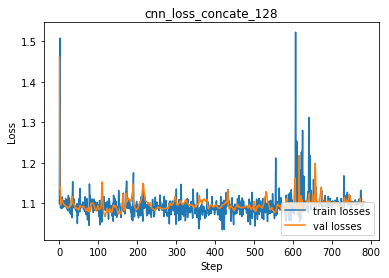

In [313]:
# CNN_CONCATE_128
# plot for losses
title = 'cnn_loss_concate_128'
plt.plot(train_losses_1, label='train losses')
plt.plot(val_losses_1, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

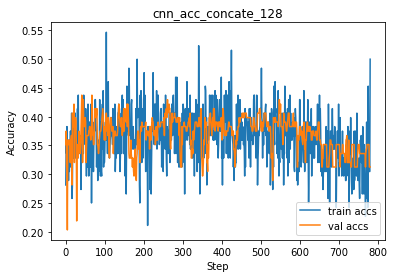

In [314]:
# CNN_CONCATE_128
# plot for accs
title = 'cnn_acc_concate_128'
plt.plot(train_accs_1, label='train accs')
plt.plot(val_accs_1, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [315]:
print(max(train_accs_1), max(val_accs_1))

0.546875 0.4375


In [ ]:
# CNN_CONCATE_256
# get number of trainable parameters
model_parameters_2 = filter(lambda p: p.requires_grad, model.parameters())
params_2 = sum([np.prod(p.size()) for p in model_parameters_2])

In [ ]:
print("Number of trainable parameters are {}.".format(params_2))

In [ ]:
train_losses_2, train_accs_2, val_losses_2, val_accs_2 = train_losses, train_accs, val_losses, val_accs

In [ ]:
# CNN_CONCATE_256
# plot for losses
title = 'cnn_loss_concate_256'
plt.plot(train_losses_2, label='train losses')
plt.plot(val_losses_2, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

In [ ]:
# CNN_CONCATE_256
# plot for accs
title = 'cnn_acc_concate_256'
plt.plot(train_accs_2, label='train accs')
plt.plot(val_accs_2, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [ ]:
print(max(train_accs_2), max(val_accs_2))

In [ ]:
# CNN_CONCATE_64
# get number of trainable parameters
model_parameters_3 = filter(lambda p: p.requires_grad, model.parameters())
params_3 = sum([np.prod(p.size()) for p in model_parameters_3])

In [ ]:
print("Number of trainable parameters are {}.".format(params_3))

In [ ]:
train_losses_3, train_accs_3, val_losses_3, val_accs_3 = train_losses, train_accs, val_losses, val_accs

In [ ]:
# CNN_CONCATE_64
# plot for losses
title = 'cnn_loss_concate_64'
plt.plot(train_losses_3, label='train losses')
plt.plot(val_losses_3, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

In [ ]:
# CNN_CONCATE_64
# plot for accs
title = 'cnn_acc_concate_64'
plt.plot(train_accs_3, label='train accs')
plt.plot(val_accs_3, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [ ]:
print(max(train_accs_3), max(val_accs_3))

In [328]:
# CNN_MULTI_128
# get number of trainable parameters
model_parameters_4 = filter(lambda p: p.requires_grad, model.parameters())
params_4 = sum([np.prod(p.size()) for p in model_parameters_4])

In [329]:
print("Number of trainable parameters are {}.".format(params_4))

Number of trainable parameters are 180200.


In [330]:
train_losses_4, train_accs_4, val_losses_4, val_accs_4 = train_losses, train_accs, val_losses, val_accs

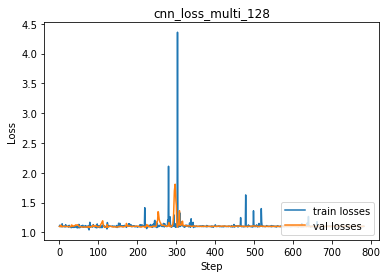

In [331]:
# CNN_MULTI_128
# plot for losses
title = 'cnn_loss_multi_128'
plt.plot(train_losses_4, label='train losses')
plt.plot(val_losses_4, label='val losses')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title(title)
plt.savefig(title + ".png")

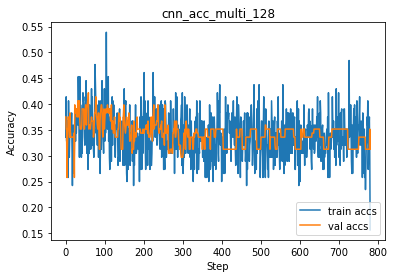

In [332]:
# CNN_MULTI_128
# plot for accs
title = 'cnn_acc_multi_128'
plt.plot(train_accs_4, label='train accs')
plt.plot(val_accs_4, label='val accs')
plt.legend(loc='lower right')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title(title)
plt.savefig(title + ".png")

In [333]:
print(max(train_accs_4), max(val_accs_4))

0.5390625 0.421875
